# IV Machine Learning: Fraud Detection
In this short notebook we will attempt to train and test a Random Forest classifier on the given fraudulent transaction dataset.

***
## Import libraries and data
We begin by importing relevant libraries, and importing and displaying our data:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

In [2]:
fraud_db = pd.read_csv('fraud_DB.csv')
display(fraud_db)

Time         V1         V2         V3         V4         V5  \
0       64968.0   1.184268   1.187882   0.296512   3.561205   0.568099   
1      128505.0   1.293556  -1.736508  -2.241085   0.393974   0.319175   
2      140125.0   2.135743   0.161594  -2.356804  -0.084458   0.171210   
3      162023.0   0.118855   0.970914  -1.679443  -1.551157  -2.127786   
4       76048.0  -0.668594   2.304054   1.015582   2.299072   0.280356   
...         ...        ...        ...        ...        ...        ...   
63357  136672.0   1.895156  -0.883775  -1.659180  -0.585291  -0.546134   
63358      32.0   1.249055  -0.832969  -0.710589  -0.991600  -0.429973   
63359   54617.0  -1.251318  -2.582220   0.381066  -1.079263  -1.482132   
63360   21046.0 -16.917468  12.893200 -23.736443  11.824990  10.830548   
63361   80520.0  -1.547786   2.128520   1.243155   0.473501   1.406962   

             V6         V7         V8           V9        V10       V11  \
0     -0.219409  -9.964008   1.235417  2210.106664  -0.872688 -0.836444   
1      0.821662  -1.379717   0.087403  2230.992204   0.616466 -0.669651   
2     -1.408117  -1.501960  -0.018695  2211.382659   0.588170  1.068503   
3      3.211279  -2.893045  -0.802105  2223.373399  -0.156839 -0.429309   
4      1.376355 -12.849960   0.720436  2224.682259   0.639728  1.431604   
...         ...        ...        ...          ...        ...       ...   
63357  3.852157   4.216075  -0.417871  2225.806122   0.033756  0.176538   
63358  3.692977   2.723047  -0.307081  2217.437547   0.229981 -0.016913   
63359  3.656327   5.639688  -0.969914  2207.848706   0.449266 -0.318533   
63360 -2.514829 -36.805019 -12.916636  2317.671103 -13.717067  0.899541   
63361 -0.681952  -6.158549   0.116001  2238.113043   0.557168 -0.214724   

             V12       V13       V14        V15       V16       V17  Class  
0       0.620870  0.032219  1.039980  -0.780803 -0.574701 -1.066637      0  
1       0.959340  0.391294 -0.673217   0.067627 -1.040020 -0.740516      0  
2       0.571448  0.309609 -0.490962  -0.560664 -0.448486  0.349756      0  
3      -0.752353  0.155298  0.215153   0.352190 -0.376009 -0.399019      0  
4       0.504526  0.772333  0.388160  -0.382188  0.286432  1.283456      0  
...          ...       ...       ...        ...       ...       ...    ...  
63357  -1.274377  2.021354  1.341615  -0.100655  0.858329 -0.989022      0  
63358  -0.220846  0.362418  0.315222  -0.512265  0.118995  0.574720      0  
63359  -0.967099 -2.150811 -0.078277  -0.261908 -0.097787  0.465006      0  
63360 -13.272965 -0.402260 -7.754094 -11.644603 -4.741303  0.584626      1  
63361   0.108745  0.839810  0.215227   0.403021  0.465726  1.152767      0  

[63362 rows x 19 columns]

In [3]:
fraud_db['Class'].value_counts()

0    59276
1     4086
Name: Class, dtype: int64

We see above that there are significantly more legitimate transactions than fraudulent ones.

We want to predict whether a transaction is fraudulent or not, and we can infer that this means that false negatives are worse than false positives. This is because it is worse to allow a fraudulent transaction to take place than to take protective measures against a legitimate one.

## Constants and scoring function
Below we set up a seed for reproducibility.

We also set up the scorer by which to perform cross validation and testing, where we use $f_\beta$ with $\beta = 4$ because we wish to minimise false negatives (reporting a transaction as legitimate when it is fraudulent).

In [4]:
seed = 42

# Wish to minimise false negatives hence maximise recall so use beta > 1
beta = 4
fbeta = make_scorer(fbeta_score, beta = beta)

***
## Preprocessing
We do not carry out much data preprocessing, only opting to use a standard scaler on the data.

In [5]:
# Train test split
X = fraud_db.drop('Class', axis = 1)
y = fraud_db.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = seed)

In [6]:
standard_scaler = StandardScaler()

X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

***
## Choosing the classifier and its parameters
Since Random Forest performed well in task III (and also performed best with default parameters on this training data), we opted to use it for this task. We carried out a cross validation grid search over the parameters `n_estimators`, `max_depth`, `min_samples_split` and `min_samples_leaf`, and found that default parameters were ideal, except with `n_estimators` being set to 50.

In [7]:
clf = RandomForestClassifier(random_state=seed, n_jobs = -1, n_estimators = 50)

clf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

***
## Testing our model
We evaluate the performance of our model using a range of different metrics, before plotting the ROC and evaluating the AUC.

In [8]:
y_pred = clf.predict(X_test_scaled)

# Evaluate different scorers
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f_beta_score = fbeta_score(y_test, y_pred, beta = beta)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"F_{beta:.3f} Score: {f_beta_score:.2f}")

Accuracy: 1.00
Recall: 0.99
Precision: 1.00
F1 Score: 0.99
F_4.000 Score: 0.99


In [9]:
fp_count = 0
fn_count = 0

for i in range(len(y_test)):
    real = y_test.iloc[i]
    pred = y_pred[i]
    if real == 1 and pred == 0:
        fn_count += 1
    if real == 0 and pred == 1:
        fp_count += 1

print(f'We observe {fn_count} false negatives and {fp_count} false positives.')

We observe 5 false negatives and 4 false positives.


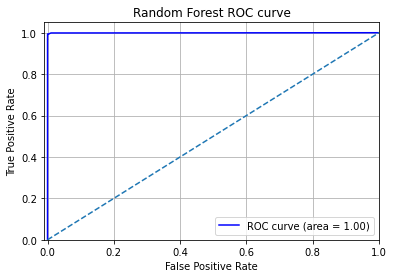

The TPR for a FPR under 0.1 is 0.9988


In [10]:
# Getting predicted probabilities
y_scores = clf.predict_proba(X_test_scaled)[:,1]  # Probabilities for the positive class

# Calculating ROC curve
fpr_random_forest_clf, tpr_random_forest_clf, _ = roc_curve(y_test, y_scores)

# Calculating AUC
random_forest_roc_auc = auc(fpr_random_forest_clf, tpr_random_forest_clf)

# Plotting ROC curve
plt.plot(fpr_random_forest_clf, tpr_random_forest_clf,
         label='ROC curve (area = {:.2f})'.format(random_forest_roc_auc), c = 'b')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

random_forest_tpr_under_max = 0

for i in range(len(fpr_random_forest_clf)):
    if fpr_random_forest_clf[i] < 0.1:
        random_forest_tpr_under_max = tpr_random_forest_clf[i]

print(f'The TPR for a FPR under 0.1 is {random_forest_tpr_under_max:.4f}')

## Conclusion
We can see that our model performes incredibly well, almost achieving a perfect score. We observe only a handful of incorrect predictions out of over 63000 data entries. This is likely because of the significant quantity of data available, which makes overfitting unlikely.

It is also possible that there is less randomness in the data, leading to a well trained model almost deterministically making the correct predictions.